# Reproducing first order phase transition of a G-protein with `paysage`

In this notebook I'll attempt to see if a trained Restricted Boltzman Machine constructed with `paysage` ( https://github.com/drckf/paysage.git ) is able to reproduce a first order phase thermodynamic transition of a specific domain of a G-protein [PDB: 1PGB]. To verify this, I'll study the resulting Mean Energy and the Heat Capacity of fantasy contact maps made by the trained RBM at different temperatures.

## Proteins and first order phase transitions
<table>
    <tr>
        <td> 
            <figure>
            <img src="img/folded.png" alt="Drawing" style="width: 250px;"/> 
            <figcaption>G-protein low-energy state.</figcaption>
            </figure>
        </td>
        <td> 
            <figure>
            <img src="img/unfolded.png" alt="Drawing" style="width: 250px;"/> 
            <figcaption>G-protein high-energy state.</figcaption>
            </figure>
        </td>
    </tr>    
</table>

Many proteins, like the G-protein, has a first order thermodynamic transition due to the fact that they are highly cooperative systems: the energy depends on the degrees of freedom of the system in a strongly coupled way or, in other words, the degrees of freedom of the system cooperate to stabilize the system. 
This means that there are few ways in which the system can have intermediate energies. It is like a tent for camping: the sticks which hold the tent can be either in place or spread on the ground, there is no intermediate situation. 

We can distinguish system undergoing a first order phase transition from their free energy $F(E) = E -TS(E)$ displaying two minima due to this depletion in the number of intermediate-energy states.
Indeed high-energy state have low free energy because of their large entropy, low-energy states have low free energy because of their also low entropy, but intermediate-energy states do not display a low enough energy nor they are enough entropically rich to sum into a low free energy.
So first order phase transitions imply a competition between energy and entropy.

We can observe first order phase transitions as a jump in the mean energy as a function of temperature and as a peak in the heat capacity given $C_v(T) = \frac{dE}{dT}$. 

## The Restricted Boltzman Machine
<table>
    <tr>
        <td> 
            <figure>
            <img src="img/rbm.png" alt="Drawing" style="width: 500px;"/> 
            <figcaption>A graphical representation of an RBM.</figcaption>
            </figure>
        </td>
    </tr>    
</table>

A Restricted Boltzman Machine (RBM) is an energy based model with both visible and hidden units where the visible and the hidden units interact with each other but do not interact among themselves.
In my case both the layers are Bernoulli, this means that every node of the layer can be $0$ or $1$.
So the energy function of my RBM takes the form:
$$
E(\textbf{v}, \textbf{h}) = -\sum_i a_i v_i -\sum_j b_j h_j -\sum_{ij} W_{ij} v_i h_j
$$
where $a_i$, $b_j$, $W_{ij}$ are the parameters that specify the model and in particular $W_{ij}$ are the weights that connect the visible and hidden units.

##### Training the model
In `paysage` the RBMs are trained using the Maximum Likelihood Estimation: first we choose as the cost function the negative log-likelihood (in this way we maximize the probability to observe tha data given our parametrized model). We can write the log-likelihood as:
$$
L(\{\theta_i\}) = <log( p(\textbf{x};{\theta_i}) )>_{data} = <E(\textbf{x};\{\theta_i\})>_{data} - log(Z(\{\theta_i\})),
$$
were we have assumed that $ p(\textbf{x};{\theta_i})$, our parametrized pdf, has a Boltzman functional form and that the partition function doesn't is indipendet from the data.
We can add also a regularization term to the cost function that prevents overfitting of the form:
$$
E_{reg}(\{\theta_i\}) = \lambda \sum_i |\theta_i|^\alpha, \alpha = 1,2
$$
with $\lambda$ controlling the strenght of the regularization. 
When $\alpha=1$ we enforce sparsity to the weights (many of them set to zero) and when $\alpha=2$ we shrink their value toward zero.

We then minimize the cost function, $C(\{\theta_i\}) = -L(\{\theta_i\}) + E_{reg}(\{\theta_i\})$, with a Stochastic Gradient Descent (SGD) method. 
To briefly recap, we update the parameters of the model according to the negative gradient of our cost function  at any step (or epoch) of our trainig procedure:
$$
\theta_i \leftarrow \theta_i - \eta \nabla_{\theta_i} C(\{\theta_i\}),
$$
with $\eta$ being the $\textit{learning rate}$.
Calculating the gradient of the cost function for the RBM is a bit different that calculating it for, say, a perceptron (where we are performing a supervised learning task and we a have labels for every element in the training set).
The gradient of the negative log-likelihood takes the form:
$$
-\frac{\partial L(\{\theta_i\})}{\partial \theta_i} = <\frac{\partial E(\textbf{x};\{\theta_i\})}{\partial \theta_i}>_{data} - \frac{\partial log(Z(\{\theta_i\}))}{\partial \theta_i},
$$
but, since we have assumed that our pdf is a Boltzman distribution, holds:
$$
<\frac{\partial E(\textbf{x};\{\theta_i\})}{\partial \theta_i}>_{p(\textbf{x};\theta_i)} = Tr_{\textbf{x}}\big[ p(\textbf{x};\theta_i) \frac{\partial E(\textbf{x};\{\theta_i\})}{\partial \theta_i} \big] = - \frac{\partial log(Z(\{\theta_i\}))}{\partial \theta_i}.
$$
In this way the gradient of the negative log-likelihood became a difference of moments, one calculated directly from the data and one calculated from our model using the current model parameters:
$$
-\frac{\partial L(\{\theta_i\})}{\partial \theta_i} = <\frac{\partial E(\textbf{x};\{\theta_i\})}{\partial \theta_i}>_{data} - <\frac{\partial E(\textbf{x};\{\theta_i\})}{\partial \theta_i}>_{p(\textbf{x};\theta_i)}.
$$

In our case, for a Bernoulli-Bernoulli RBM, the gradient of the log-likelihood became:
$$
\frac{\partial L(\{W_{ij},a_i,b_j\})}{\partial W_{ij}} = <v_i h_j>_{data} - <v_i h_j>_{model}\\
\frac{\partial L(\{W_{ij},a_i,b_j\})}{\partial a_i} = <v_i>_{data} - <v_i>_{model} \\
\frac{\partial L(\{W_{ij},a_i,b_j\})}{\partial b_j} = <h_j>_{data} - <h_j>_{model}.
$$
The first terms, known as the $\textit{positive phase}$, can be easly calculated using samples from the training dataset. The second terms, known as the $\textit{negative phase}$, is generally much more difficult to compute. The fundamental reason for this is that it is impossible to calculate the partition function exactly for most interesting models, as in physics. So we have to estimate expectation values numerically drawing samples from the model.

The bipartite interaction structure of an RBM makes it possible to calculate expectation values using a Markov Chain Monte Carlo (MCMC) method know as Gibbs sampling. 
We can think at this method as a Metropolis-Hastings method where the $\textit{proposal}$ distribution, the one from we draw the samples, is written in term of conditional probabilities of the $p(\textbf{x};\{\theta_i\})$.
Since there are no interaction of visible units with themeselves or hidden units with themeselves, the visible and hidden units of an RBM are conditionally indipendent:
$$
p(\textbf{v}|\textbf{h}) = \prod_i p(v_i|\textbf{h}) \\
p(\textbf{h}|\textbf{v}) = \prod_j p(h_j|\textbf{v}),
$$
with (using Bayes' theorem)
$$
p(v_i = 1|\textbf{h}) = \sigma \Big( a_i + \sum_j W_{ij} h_j  \Big)\\
p(h_j = 1|\textbf{v}) = \sigma \Big( b_j + \sum_i W_{ij} v_i  \Big)
$$
and where $\sigma(z) = \frac{1}{1+e^{-z}}$ is the $\textit{sigmoid}$ function. 

So, in order to calculate the positive phase we take as the input a minibatch of observed data. For each sample in the minibatch we simply clamp the visible units to the observed values and infer the state $\textbf{h}$ of the hidden variables from the conditional distribution $p(\textbf{h}|\textbf{v})$. 
We then average over all samples in the minibatch to calculate the expectation values with respect  to the data.
To calculate the negative phase we use Gibbs sampling: we start again from sample from the minibatch and run a Markov Chain for $k$ steps, sampling each layer using the exact conditional distibutions:
$$
\textbf{v}^{(0)} \rightarrow \textbf{h}^{(0)} \sim p(\textbf{h}|\textbf{v}^{(0)}) \rightarrow \textbf{v}^{(1)} \sim p(\textbf{v}|\textbf{h}^{(0)}) \rightarrow ... \rightarrow \textbf{v}^{(k)} \sim p(\textbf{v}|\textbf{h}^{(k-1)}) \rightarrow \textbf{h}^{(k)} \sim p(\textbf{h}|\textbf{v}^{(k)}).
$$
The sample are guaranteed to converge to the equilibrium distribution of the model in the limit $k\rightarrow \inf$. 
At the end of the Gibbs sampling procedure, one ends up with a minibatch of samples called $\textit{fantasy particles}$.
This training algo is called $\textit{Contrastive Divergence}$ (CD$_k$). Usually the order $k$ of the chain is very low due to the fact that the initial state of the chain is a sample from the data set and thus it already belongs to the distribution, there is no need for a long equilibration.

In this work I used a slightly different sampling procedure called $\textit{Persistent Contrastive Divergence}$ (PCD$_k$).
In PCD$_k$, rather then restarting the Gibbs sampler from the data at each gradient descent step, we start the Gibbs sampling at the fantasy particles in the last gradient descent step.
The advantage to doing so is to allow PCD$_k$ to explore parts of the feature space that are much further from the training dataset than one could reach with ordinary CD$_k$.

To recap, our goal is to fit the parameters of a model $ p(\textbf{x};\{ \theta_i \}) = e^{-E(\textbf{x};\{ \theta_i \})} / Z(\{ \theta_i \})$. The training procedure involves the steps:

- Read a minibatch of data, $\{ \textbf{x}_n \}$;
- Generate a minibatch of fantasy particles$\{ \textbf{x'}_n \} \sim p(\textbf{x};\{ \theta_i \})$ using PCD$_k$;
- Compute the gradient of the negative log-likelihood using these samples for calculating the mean values taken over the minibatch of data and the fantasy particles, respectively for the positive and negative phase;
- Use the gradient to update the parameters.

## Results
For the results of this section I worked with an RBM with only one hidden unit. I used the ADAM as stochastic gradient descent method that implement a new parameter called $\textit{momentum}$ (that the method change in an adaptive way) that prevents the model to stuck in a local minima. 
I trained the model for $60$ epochs using $k=10$ markov steps for the PCD.
I used a scheduler to change the learning rate as the epochs increases according to the power law decay: $\eta(t+1) = \eta(t)/( 1+\alpha \eta(t) )$ with $\alpha=0.1$ and $\eta(0)=0.01$. 
I also add an L2 regularization term to the cost function with coefficient $\lambda=0.001$.
Lastly, I inizialized the weights with a function of `paysage` called `hinton` that uses the method described in:
Hinton, Geoffrey(2012),"A practical guide to training restricted Boltzmann machines". The weights $W_{ij}$ are taken from a gaussian with mean zero and $\sigma=0.01$, the hidden biases ($b_j$) are set to zero and the visible biases ($a_i$) are set to the inverse mean of $v_i$.

In [14]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### (i) Model parameters

##### KL and reverse KL divergence
During the training of the model I print the Kullbakc-Lieber divergence and the reverse KL-div for every new epoch. This two are important quantities that says how much different is my approximate distribution from the true one. 
They are defined respectively as:
$$
D_{KL}(p(x)||q(x)) = \int dx p(x)log\Big(\frac{p(x)}{q(x)}\Big),\\
D_{KL}(q(x)||p(x)) = \int dx q(x)log\Big(\frac{q(x)}{p(x)}\Big),
$$
where $p(x)$ is the true pdf and $q(x)$ the approximate one.
In `paysage` is used the "Divergence Estimation for Multidimensional Densities Via k-Nearest Neighbor Distances" by Qing Wang, Sanjeev R. Kulkarni and Sergio Verdú in order to estimate the KL divergence between two samples.

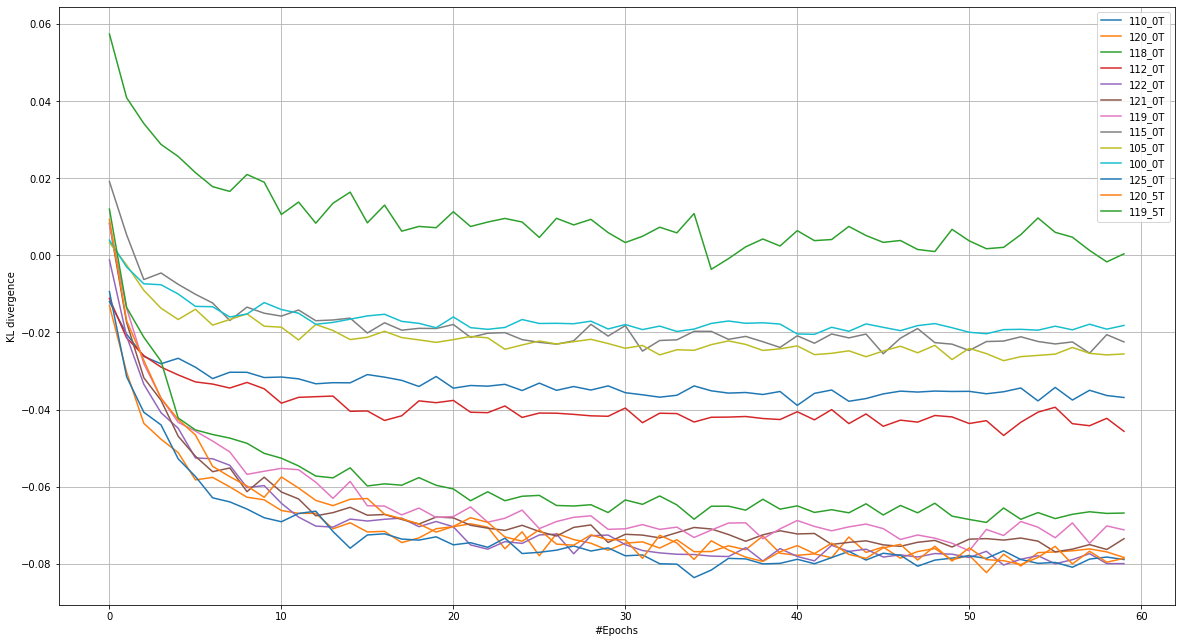

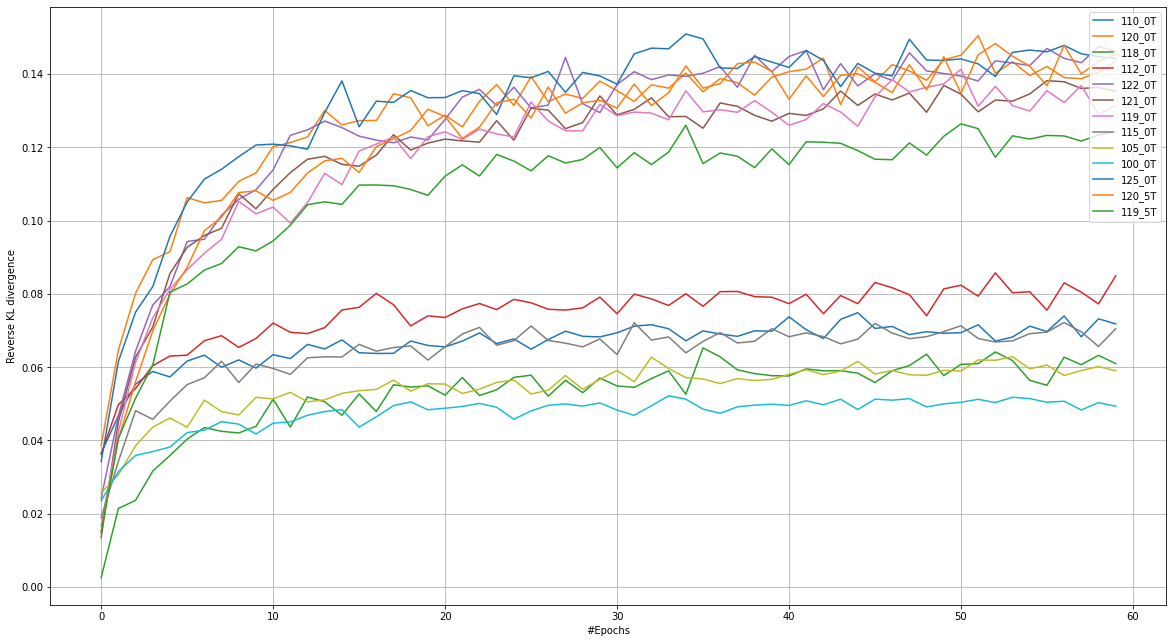

In [29]:
# KL divergence
plt.figure(figsize=(20,11))
for temperature in os.listdir("../results/01HiddenUnits/KL-div"):
    vec_KL_div = np.loadtxt("../results/01HiddenUnits/KL-div/"+temperature, usecols=0)
    n_epochs = np.arange(vec_KL_div.shape[0])
    plt.plot(n_epochs, vec_KL_div,label=temperature[21:-4])
    
plt.xlabel('#Epochs') 
plt.ylabel('KL divergence')
plt.grid(True)
plt.legend(loc="upper right")

# Reverse KL divergence
plt.figure(figsize=(20,11))
for temperature in os.listdir("../results/01HiddenUnits/KL-div"):
    vec_KL_div = np.loadtxt("../results//01HiddenUnits/KL-div/"+temperature, usecols=1)
    n_epochs = np.arange(vec_KL_div.shape[0])
    plt.plot(n_epochs, vec_KL_div,label=temperature[21:-4])
    
plt.xlabel('#Epochs') 
plt.ylabel('Reverse KL divergence')
plt.grid(True)
plt.legend(loc="upper right")

We see that something is wrong in the KL divergence due to the fact that, although it decreases with the epochs, his positivity (garanted by the Gibbs inequality) is not respected. I suspect that something went wrong with its calculation because going on with the study, plotting for example the resulting weights, we can see that the training of the model is been successful.

So we cannot rely on the KL divergence to understand if our model is approximating good our true probability distribution.

##### Weights
Generative models, as the name suggests, are useful to generate brand new data (images) by learning how to imitate the ones from a given data set. 
This is achieved by extracting/learning a set of features which represent the backbone of the entire data and are thus definitive for the particular dataset. 
These features are encoded in the weights of the model.
So, we can plot the values of the single weights $W_{ij}$ at the and of this 60 Epochs, in order to see what important features the model has learned and, most importantly, if the model has actually learned something:

<table>
    <tr>
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-100_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 100 [GROMACS REF T]</figcaption>
            </figure>
        </td>
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-110_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 110 [GROMACS REF T]</figcaption>
            </figure>
        </td>
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-115_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 115 [GROMACS REF T]</figcaption>
            </figure>
        </td>
    </tr>
    <tr>
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-120_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 120 [GROMACS REF T]</figcaption>
            </figure>
        </td>    
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-122_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 122 [GROMACS REF T]</figcaption>
            </figure>
        </td>
        <td> 
            <figure>
            <img src="../results/OLD/01HiddenUnits/weights/weights-sim-125_0T.jpg" alt="Drawing" style="width: 250px;"/> 
            <figcaption>Temperature: 125 [GROMACS REF T]</figcaption>
            </figure>
        </td>    
    </tr>    
</table>

As we can see from this picture, where the weights are reshaped as a contact map, we find the highest weights in the same place of the contacts of the characterizing structure of the protein at a certain temperature. 
For example we can see that the contact from the first $\beta$-harpin and the last, represented by the small oblique line in the top right corner of the images, disappears as the temperature increases.
This is a consequence of the form of the coditional probabilities that are used during the pcd procedures that have a functional form of a sigmoid centered in zero: higher is a weight, higher is the probability that a specific node is equal to $1$.

### (ii) Comparison of fantasy and real contact maps 
Once that the RBM is trained at a certain temperature, we can compute as many fantasy contact maps as we want. 
In the next image are showed, for different temperatures, the average and the variance of the single contacts over $10^4$ fantasy contact maps side by side with the average and the variance of the single contacts over $10^4$ real contact maps used during the trainig procedure.
Both, the averages and the variances, are reshaped as done as for the weights $W_{ij}$.

<table>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/mean_fantasy_cmap/mean_cmap-sim-100_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/mean_cmap/mean_cmap-sim-100_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>
        </td>    
    </tr>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/variance_fantasy_cmap/variance_cmap-sim-100_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Fantasy cmap -Temperature: 100 [GROMACS REF T]</figcaption>
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/variance_cmap/variance_cmap-sim-100_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Real cmap -Temperature: 100 [GROMACS REF T]</figcaption>
            </figure>
        </td>    
    </tr>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/mean_fantasy_cmap/mean_cmap-sim-118_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/mean_cmap/mean_cmap-sim-118_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>
        </td>    
    </tr>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/variance_fantasy_cmap/variance_cmap-sim-118_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Fantasy cmap -Temperature: 118 [GROMACS REF T]</figcaption>
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/variance_cmap/variance_cmap-sim-118_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Real cmap -Temperature: 118 [GROMACS REF T]</figcaption>
            </figure>
        </td>    
    </tr>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/mean_fantasy_cmap/mean_cmap-sim-125_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/mean_cmap/mean_cmap-sim-125_0T.png" alt="Drawing" style="width: 250px;"/> 
            </figure>
        </td>    
    </tr>
    <tr>
        <td> 
           <figure>
                <img src="../results/01HiddenUnits/variance_fantasy_cmap/variance_cmap-sim-125_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Fantasy cmap -Temperature: 125 [GROMACS REF T]</figcaption>
            </figure>        
        </td>
        <td>
            <figure>
                <img src="img/variance_cmap/variance_cmap-sim-125_0T.png" alt="Drawing" style="width: 250px;"/> 
                <figcaption>Real cmap -Temperature: 125 [GROMACS REF T]</figcaption>
            </figure>
        </td>    
    </tr>
</table>

We can see that the RBM is quite able to reproduce the first moment of the distribution of each single contact, but the variance in most cases is pourly reproduced.

### (iii) Mean energy and Heat capacity
From every contact map, I calculate the energy of the single configuration as the sum over the contacts $c_i$ normalized over the total number of contacts $ C = 1540 $:
$$
E^{(k)} = -\frac{1}{C} \sum_{i=0}^C c_i,
$$
where $c_i = 1$ if the distance between residues i and j is smaller than a threshold (3.5 Angstrom in my case), and $k$ is an index that occurs over the distincts temperatures. In this way an energy equal to $-\frac{1}{C}$ is associated to every contact. 

For the calculation of the mean and the variance of the energy I've used the blocking method: given the total number of contact map $M$, I've splitted it in $N=100$ blocks. Say that in each block you want to obtain an estimate of a certain quantity $A$, you can do it by using $L=M/N$ contact maps. Then you have $A_i$ with $i=1,N$ estimate of your quantity and also $A^2_i$ with $i=1,N$, with which you can compute the statistical uncertainty with $N$:
$$
\frac{\sigma_A}{\sqrt{N-1}} \simeq \sqrt{\frac{1}{N-1} \left[ \frac{1}{N} \sum_{i=1}^N A^2_i - \left( \frac{1}{N} \sum_{i=1}^N A_i \right)^2 \right]} 
$$
In my case:
$$
A^{(k)}_i = <E^{(k)}>_i = \frac{1}{L} \sum_{j=0}^L E_j^{(k)},
$$
with $i=1,N$ and $k$ being always the index over the different temperatures.

I've used the blocking method for calculate also the Heat Capacity (and the associate statistical uncertanity) of the system at the different temperatures.
To estimate it I can use the variance of the total energy $E^{(k)}$ due to the fluctuation-dissipation theorem: 
$$
C^{(k)}_v \propto \frac{1}{[T^{(k)}]^2} [\sigma^2_E]^{(k)},
$$
with the variance being:
$$
[\sigma^2_E]^{(k)} = <[E^{(k)}]^2> - [<E^{(k)}>]^2.
$$
So in this case $A^{(k)}_i =C^{(k)}_{v,i}$ with $i=1,N$.

I repeat this calculation with the contact maps with which I train the RBM (real-cmap) and the contact maps computed by the RBM (fantasy-cmap).
For real-cmap $M=10^4$ for every temperature, and for fantasy-cmap $M=10^5$ for every temperature.

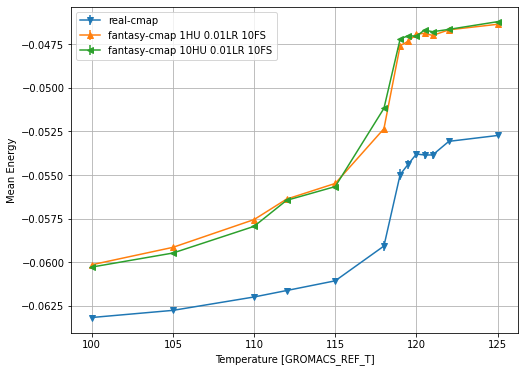

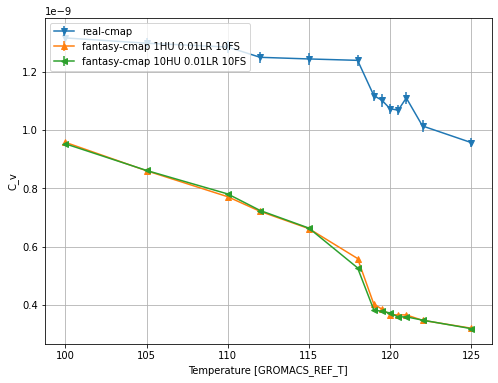

In [26]:
### Load vectors with data
# Real cmap
real_cmap_results = np.loadtxt("../results/thermodynamic-real-cmap.dat")
real_cmap_results_sorted = real_cmap_results[real_cmap_results[:,0].argsort()]

temperature_real_cmap = real_cmap_results_sorted[:,0]
real_cmap_mean_energy = -real_cmap_results_sorted[:,1]
real_cmap_std_dev = real_cmap_results_sorted[:,2]
real_cmap_heat_capacity = real_cmap_results_sorted[:,3]/temperature_real_cmap**2
real_cmap_std_dev_hc = real_cmap_results_sorted[:,4]/temperature_real_cmap**2

# Fantasy cmap - 1Hidden Unit 0.01 Learning Rate 10 Fantasy steps
fantasy_cmap_results_01HiddenUnits = np.loadtxt("../results/01HiddenUnits/thermodynamic-fantasy-cmap.dat")
fantasy_cmap_results_01HiddenUnits_sorted = fantasy_cmap_results_01HiddenUnits[fantasy_cmap_results_01HiddenUnits[:,0].argsort()]

temperature_fantasy_cmap_01HiddenUnits = fantasy_cmap_results_01HiddenUnits_sorted[:,0]
fantasy_cmap_mean_energy_01HiddenUnits = -fantasy_cmap_results_01HiddenUnits_sorted[:,1]
fantasy_cmap_std_dev_01HiddenUnits = fantasy_cmap_results_01HiddenUnits_sorted[:,2]
fantasy_cmap_heat_capacity_01HiddenUnits = fantasy_cmap_results_01HiddenUnits_sorted[:,3]/temperature_fantasy_cmap_01HiddenUnits**2
fantasy_cmap_std_dev_hc_01HiddenUnits = fantasy_cmap_results_01HiddenUnits_sorted[:,4]/temperature_fantasy_cmap_01HiddenUnits**2

# Fantasy cmap - 10 Hidden Unit 0.01 Learning Rate 10 Fantasy steps
fantasy_cmap_results_10HiddenUnits = np.loadtxt("../results/10HiddenUnits/thermodynamic-fantasy-cmap.dat")
fantasy_cmap_results_10HiddenUnits_sorted = fantasy_cmap_results_10HiddenUnits[fantasy_cmap_results_10HiddenUnits[:,0].argsort()]

temperature_fantasy_cmap_10HiddenUnits = fantasy_cmap_results_10HiddenUnits_sorted[:,0]
fantasy_cmap_mean_energy_10HiddenUnits = -fantasy_cmap_results_10HiddenUnits_sorted[:,1]
fantasy_cmap_std_dev_10HiddenUnits = fantasy_cmap_results_10HiddenUnits_sorted[:,2]
fantasy_cmap_heat_capacity_10HiddenUnits = fantasy_cmap_results_10HiddenUnits_sorted[:,3]/temperature_fantasy_cmap_10HiddenUnits**2
fantasy_cmap_std_dev_hc_10HiddenUnits = fantasy_cmap_results_10HiddenUnits_sorted[:,4]/temperature_fantasy_cmap_10HiddenUnits**2
'''
# Fantasy cmap - 1Hidden Unit 0.1 Learning Rate 10 Fantasy steps
fantasy_cmap_results_0_1LearningRate = np.loadtxt("../results/0_1LearningRate/energy-vs-var-fantasy-cmap.dat")
fantasy_cmap_results_0_1LearningRate_sorted = fantasy_cmap_results_0_1LearningRate[fantasy_cmap_results_0_1LearningRate[:,0].argsort()]

temperature_fantasy_cmap_0_1LearningRate = fantasy_cmap_results_0_1LearningRate_sorted[:,0]
fantasy_cmap_mean_energy_0_1LearningRate = -fantasy_cmap_results_0_1LearningRate_sorted[:,1]
fantasy_cmap_heat_capacity_0_1LearningRate = fantasy_cmap_results_0_1LearningRate_sorted[:,2]/temperature_fantasy_cmap_0_1LearningRate**2
fantasy_cmap_std_dev_0_1LearningRate = np.sqrt(fantasy_cmap_results_0_1LearningRate_sorted[:,2])

# Fantasy cmap - 1Hidden Unit 0.01 Learning Rate 100 Fantasy steps
fantasy_cmap_results_100FantasySteps = np.loadtxt("../results/100FantasySteps/energy-vs-var-fantasy-cmap.dat")
fantasy_cmap_results_100FantasySteps_sorted = fantasy_cmap_results_100FantasySteps[fantasy_cmap_results_100FantasySteps[:,0].argsort()]

temperature_fantasy_cmap_100FantasySteps = fantasy_cmap_results_100FantasySteps_sorted[:,0]
fantasy_cmap_mean_energy_100FantasySteps = -fantasy_cmap_results_100FantasySteps_sorted[:,1]
fantasy_cmap_heat_capacity_100FantasySteps = fantasy_cmap_results_100FantasySteps_sorted[:,2]/temperature_fantasy_cmap_100FantasySteps**2
fantasy_cmap_std_dev_100FantasySteps = np.sqrt(fantasy_cmap_results_100FantasySteps_sorted[:,2])
'''
### Plot Mean energy vs temperature
plt.figure(figsize=(8,6))
# Real cmap
plt.errorbar(temperature_real_cmap, real_cmap_mean_energy, 
             yerr=real_cmap_std_dev,marker='v',label="real-cmap")
# Fantasy cmap
plt.errorbar(temperature_fantasy_cmap_01HiddenUnits, fantasy_cmap_mean_energy_01HiddenUnits, 
             yerr=fantasy_cmap_std_dev_01HiddenUnits, marker='^',label="fantasy-cmap 1HU 0.01LR 10FS")
plt.errorbar(temperature_fantasy_cmap_10HiddenUnits, fantasy_cmap_mean_energy_10HiddenUnits, 
             yerr=fantasy_cmap_std_dev_10HiddenUnits, marker='<',label="fantasy-cmap 10HU 0.01LR 10FS")
#plt.errorbar(temperature_fantasy_cmap_0_1LearningRate, fantasy_cmap_mean_energy_0_1LearningRate, 
#             yerr=fantasy_cmap_std_dev_0_1LearningRate, marker='>',label="fantasy-cmap 1HU 0.1LR 10FS")
#plt.errorbar(temperature_fantasy_cmap_100FantasySteps, fantasy_cmap_mean_energy_100FantasySteps, 
#             yerr=fantasy_cmap_std_dev_100FantasySteps, marker='s',label="fantasy-cmap 1HU 0.01LR 100FS")

plt.xlabel('Temperature [GROMACS_REF_T]') 
plt.ylabel('Mean Energy')
plt.grid(True)
plt.legend(loc="upper left")

plt.figure(figsize=(8,6)) # New figure for separated plots

### Plot Heat Capacity vs temperature
# Real cmap
#plt.plot(temperature_real_cmap, (real_cmap_std_dev**2)/temperature_real_cmap**2,label="real-cmap",marker='v')
plt.errorbar(temperature_real_cmap, real_cmap_heat_capacity, 
             yerr=real_cmap_std_dev_hc, marker='v',label="real-cmap")

# Fantasy cmap
plt.errorbar(temperature_fantasy_cmap_01HiddenUnits, fantasy_cmap_heat_capacity_01HiddenUnits, 
             yerr=fantasy_cmap_std_dev_hc_01HiddenUnits, marker='^',label="fantasy-cmap 1HU 0.01LR 10FS")
plt.errorbar(temperature_fantasy_cmap_10HiddenUnits, fantasy_cmap_heat_capacity_10HiddenUnits, 
             yerr=fantasy_cmap_std_dev_hc_10HiddenUnits, marker='<',label="fantasy-cmap 10HU 0.01LR 10FS")
'''
plt.plot(temperature_fantasy_cmap_0_1LearningRate, fantasy_cmap_heat_capacity_0_1LearningRate,
         label="fantasy-cmap 1HU 0.1LR 10FS",marker='<') 
plt.plot(temperature_fantasy_cmap_100FantasySteps, fantasy_cmap_heat_capacity_100FantasySteps,
         label="fantasy-cmap 1HU 0.01LR 100FS",marker='s') 
'''
plt.xlabel('Temperature [GROMACS_REF_T]') 
plt.ylabel('C_v')
plt.grid(True)
plt.legend(loc="upper left")

plt.show()

## Conclusions

Unfortunately my first attempt of RBM seems not being able to reproduce correctly the first order phase transition. There is a jump in the mean energy but it is far out of the statistical uncertainity of the true mean energy.
Increasing the complexity of the model adding hidden units (HU), or giving the model more freedom to explore the parameters space increasing the initial value of the learning rate (LR), seems to be not the right ways to fix this inability of the RBM. 
I also try to increase the number of steps (FS) in the equilibration process during the creation of the fantasy particles after the RBM has been trained, but the machine is not still able to reproduce correctly the phase transition.
This incapability of the machine could be caused by the high sparsity of the data: only a hundred variables are not zero over the total $1540$.
However this remain only a mere speculation due to the fact that I don't know how to prove it. 

I didn't succeed in reproducing the peak in the heat capacity that I expected to observe, due to the phase transition. Probably there's a bug in the way I calculate the variance of the total energy. 